In [1]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="Climt1",          # --job-name
    cores=48,                   # 24 cores per node
    processes=4,                # One process per task
    memory="400GB",             # --mem
    walltime="01:15:00",        # --time
    queue="med",                # --partition
    log_directory=".",          # Logs will be saved to the current directory
)


import glob 
import os

/home1/nalex2023/.local/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44561 instead
  warnings.warn(


2025-07-08 11:07:27,147 - distributed.scheduler - ERROR - Task open_dataset-6cdcf833-d768-4296-ad11-7c421b3c86d9 marked as failed because 4 workers died while trying to run it
2025-07-08 11:07:27,149 - distributed.scheduler - ERROR - Task open_dataset-b981b2b6-3542-4e44-9fe5-6414f08c7dbd marked as failed because 4 workers died while trying to run it
2025-07-08 11:07:27,151 - distributed.scheduler - ERROR - Task open_dataset-98f7d9ba-2344-4366-b8e2-533a9e1f3a7b marked as failed because 4 workers died while trying to run it
2025-07-08 11:07:27,153 - distributed.scheduler - ERROR - Task open_dataset-5f0fbd30-b5a1-4a56-9643-ead5b48c5281 marked as failed because 4 workers died while trying to run it
2025-07-08 11:07:27,154 - distributed.scheduler - ERROR - Task open_dataset-65ae7514-b244-4d6d-ae15-da4551e9da62 marked as failed because 4 workers died while trying to run it
2025-07-08 11:07:27,156 - distributed.scheduler - ERROR - Task open_dataset-0da41e38-8e96-4735-9c02-ad9b969b83b5 marked 

In [6]:
from dask.distributed import Client
cluster.scale(jobs=2)
client = Client(cluster)

client

<Client: 'tcp://10.42.239.61:41555' processes=16 threads=192, memory=1.46 TiB>

In [8]:
client.restart()


In [9]:
data_dir = '/home2/nalex2023/Datasets/interpsonde_manus/*.nc'

all_dsets = glob.glob(data_dir)

all_dsets

['/home2/nalex2023/Datasets/interpsonde_manus/2004_MANUS_INTERPSONDEv2.nc',
 '/home2/nalex2023/Datasets/interpsonde_manus/2013_MANUS_INTERPSONDEv2.nc',
 '/home2/nalex2023/Datasets/interpsonde_manus/2012_MANUS_INTERPSONDEv2.nc',
 '/home2/nalex2023/Datasets/interpsonde_manus/2005_MANUS_INTERPSONDEv2.nc',
 '/home2/nalex2023/Datasets/interpsonde_manus/2010_MANUS_INTERPSONDEv2.nc',
 '/home2/nalex2023/Datasets/interpsonde_manus/2007_MANUS_INTERPSONDEv2.nc',
 '/home2/nalex2023/Datasets/interpsonde_manus/2006_MANUS_INTERPSONDEv2.nc',
 '/home2/nalex2023/Datasets/interpsonde_manus/2011_MANUS_INTERPSONDEv2.nc',
 '/home2/nalex2023/Datasets/interpsonde_manus/2009_MANUS_INTERPSONDEv2.nc',
 '/home2/nalex2023/Datasets/interpsonde_manus/2002_MANUS_INTERPSONDEv2.nc',
 '/home2/nalex2023/Datasets/interpsonde_manus/2003_MANUS_INTERPSONDEv2.nc',
 '/home2/nalex2023/Datasets/interpsonde_manus/2008_MANUS_INTERPSONDEv2.nc',
 '/home2/nalex2023/Datasets/interpsonde_manus/2014_MANUS_INTERPSONDEv2.nc',
 '/home2/nal

In [10]:
import xarray as xr 
import pandas as pd
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units

dset = xr.open_mfdataset(all_dsets, combine='by_coords').sel(time='2012')
dset['height'] = dset['height'] * 1000
dset['time'] = dset['time'].roll(time=10)

dset = dset.sortby('time')

In [11]:
dft_met = pd.DataFrame(glob.glob('/home2/nalex2023/Datasets/met_manus/*.cdf'), columns=['file_path'])

dft_met['datetime'] = dft_met['file_path'].str.split('.').str[-3]

dft_met['datetime'] = pd.to_datetime(dft_met['datetime'], format='%Y%m%d')

dft_met_2012 = dft_met[dft_met['datetime'].dt.year == 2012].reset_index(drop=True)
# first 10 days of 2012 January
dft_met_2012 = dft_met_2012[dft_met_2012['datetime'].dt.month == 1]
dft_met_2012 = dft_met_2012[dft_met_2012['datetime'].dt.day <= 10].reset_index(drop=True)




def prepro(dset):
    dset_re = dset.resample(time='30min').mean()
    return dset_re
met_dset = xr.open_mfdataset(dft_met_2012['file_path'].values,parallel=True,preprocess=prepro)



In [ ]:
met_dset['org_precip_rate_mean']

<xarray.Dataset> Size: 180kB
Dimensions:                       (time: 480)
Coordinates:
  * time                          (time) datetime64[ns] 4kB 2012-01-01 ... 20...
Data variables: (12/60)
    base_time                     (time) datetime64[ns] 4kB 2012-01-01 ... 20...
    qc_time                       (time) float64 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    atmos_pressure                (time) float32 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    qc_atmos_pressure             (time) float64 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    temp_mean                     (time) float32 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    qc_temp_mean                  (time) float64 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    ...                            ...
    qc_logger_volt                (time) float64 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    logger_temp                   (time) float32 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    qc_logger_temp                (time) float64 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    lat                           (time) float32 2kB -2.06 -2.06 ... -2.06 -2.06
    lon                           (time) float32 2kB 147.4 147.4 ... 147.4 147.4
    alt                           (time) float32 2kB 4.0 4.0 4.0 ... 4.0 4.0 4.0
Attributes: (12/31)
    command_line:                met_ingest -s twp -f C1
    process_version:             ingest-met-4.7-0.el5
    dod_version:                 met-b1-3.2
    site_id:                     twp
    facility_id:                 C1: Momote, Manus Island
    data_level:                  b1
    ...                          ...
    qc_bit_3_description:        Value is greater than the valid_max.
    qc_bit_3_assessment:         Bad
    qc_bit_4_description:        Difference between current and previous valu...
    qc_bit_4_assessment:         Indeterminate
    zeb_platform:                twpmetC1.b1
    history:                     created by user dsmgr on machine gold at 1-J...

In [59]:
met_dset_local = met_dset[['wspd_arith_mean','wdir_vec_mean','org_precip_rate_mean']].roll(time=10)

In [94]:
met_dset_local_jan3 = met_dset_local.sel(time='2012-01-03')




In [95]:
met_dset_local_jan3

<xarray.Dataset> Size: 960B
Dimensions:               (time: 48)
Coordinates:
  * time                  (time) datetime64[ns] 384B 2012-01-03 ... 2012-01-0...
Data variables:
    wspd_arith_mean       (time) float32 192B dask.array<chunksize=(1,), meta=np.ndarray>
    wdir_vec_mean         (time) float32 192B dask.array<chunksize=(1,), meta=np.ndarray>
    org_precip_rate_mean  (time) float32 192B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/31)
    command_line:                met_ingest -s twp -f C1
    process_version:             ingest-met-4.7-0.el5
    dod_version:                 met-b1-3.2
    site_id:                     twp
    facility_id:                 C1: Momote, Manus Island
    data_level:                  b1
    ...                          ...
    qc_bit_3_description:        Value is greater than the valid_max.
    qc_bit_3_assessment:         Bad
    qc_bit_4_description:        Difference between current and previous valu...
    qc_bit_4_assessment:         Indeterminate
    zeb_platform:                twpmetC1.b1
    history:                     created by user dsmgr on machine gold at 1-J...

<Axes: xlabel='time'>

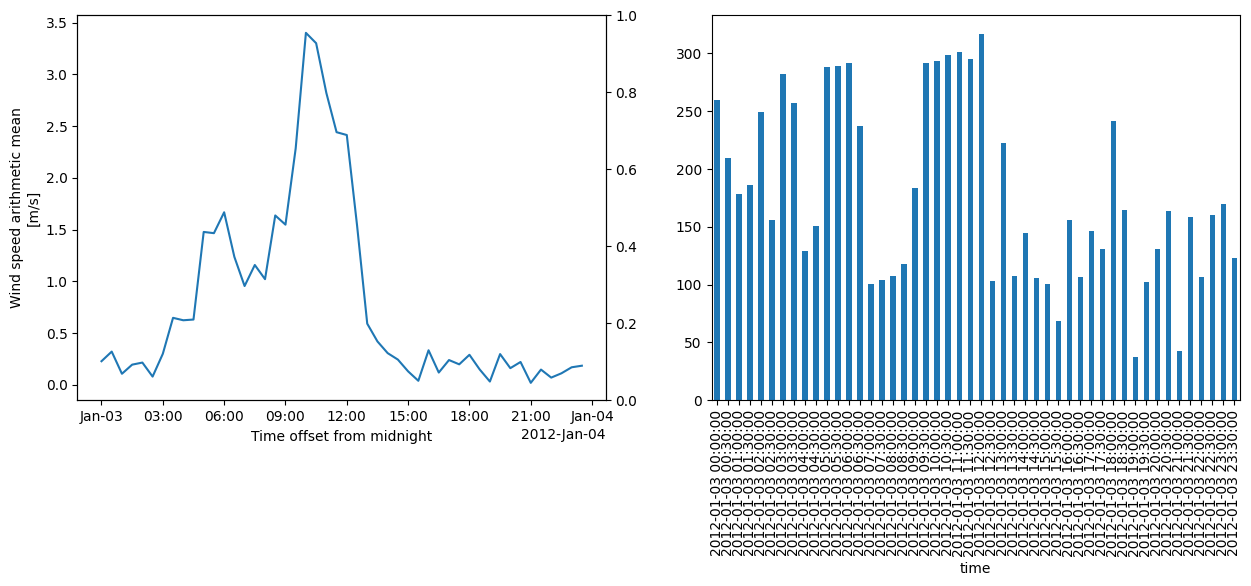

In [96]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes


fig,ax = plt.subplots(1,2,figsize=(15,5))
met_dset_local_jan3.wspd_arith_mean.plot(ax=ax[0])
ax2 = ax[0].twinx()

met_dset_local_jan3.wdir_vec_mean.to_series().plot.bar(ax=ax[1])


# wind rose plot


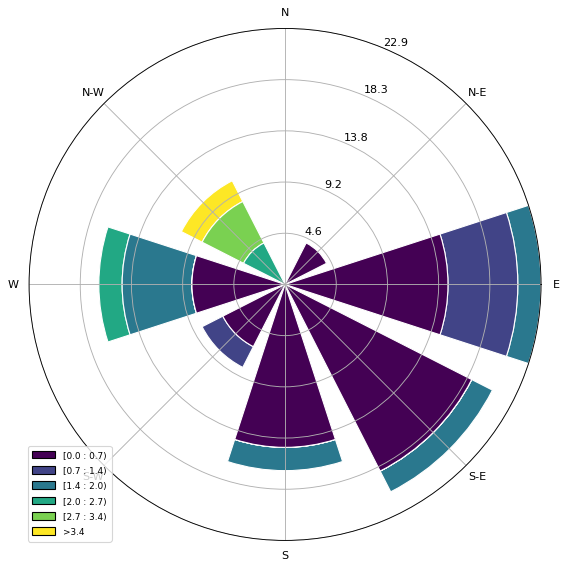

In [97]:
# wind rose plot in degrees

ax = WindroseAxes.from_ax()
ax.bar(met_dset_local_jan3.wdir_vec_mean.values, met_dset_local_jan3.wspd_arith_mean.values, normed=True, opening=0.8, edgecolor='white', nsector=8, cmap=plt.cm.viridis)
ax.set_legend()

ImportError: cannot import name 'docstring' from 'matplotlib' (/home1/nalex2023/.local/lib/python3.10/site-packages/matplotlib/__init__.py)

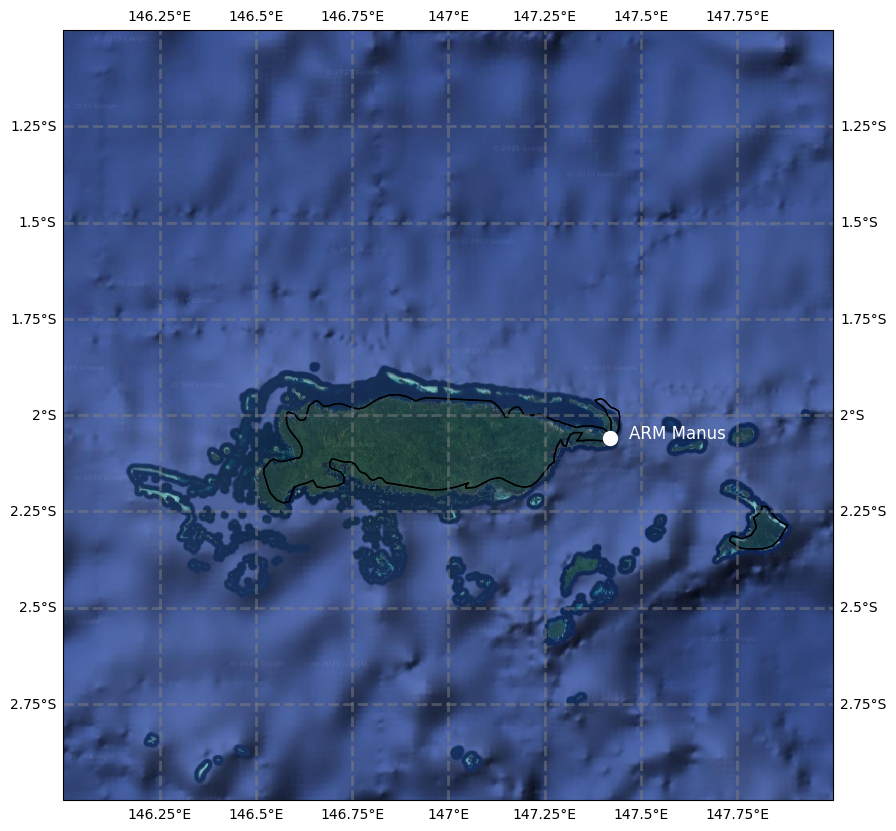

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig,ax = plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
import matplotlib.pyplot as plt
# add the tick lines/ gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax.set_extent([146,148,-3,-1],crs=ccrs.PlateCarree())   

ax.coastlines() 
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
from cartopy.io.img_tiles import GoogleTiles
# add satellite imagery cartopy 

# tile = http://mt0.google.com/vt/lyrs=s&hl=en&x={x}&y={y}&z={z}

terrain = GoogleTiles(style='satellite')

ax.add_image(terrain, 10)

arm_lat , arm_lon = -2.06, 147.42

ax.plot(arm_lon,arm_lat,marker='o',color='white',markersize=10,transform=ccrs.PlateCarree())

ax.text(arm_lon + 0.05,arm_lat,'ARM Manus',transform=ccrs.PlateCarree(),fontsize=12,color='white')

# overlay the wind rose plot on the map do not use inset_axes




Found existing installation: matplotlib 3.10.3
Uninstalling matplotlib-3.10.3:
  Would remove:
    /home1/nalex2023/.local/lib/python3.10/site-packages/matplotlib-3.10.3.dist-info/*
    /home1/nalex2023/.local/lib/python3.10/site-packages/matplotlib/*
    /home1/nalex2023/.local/lib/python3.10/site-packages/mpl_toolkits/axes_grid1/*
    /home1/nalex2023/.local/lib/python3.10/site-packages/mpl_toolkits/axisartist/*
    /home1/nalex2023/.local/lib/python3.10/site-packages/mpl_toolkits/mplot3d/*
    /home1/nalex2023/.local/lib/python3.10/site-packages/pylab.py
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.
